# Merge Sort

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/mergesort.ipynb)

## Implementing Merge Sort

[Merge sort](https://en.wikipedia.org/wiki/Merge_sort) is a divide and conquer strategy:

1. Divide the sequence into two halves,

2. Sort the halves, and

3. Merge the sorted sub-sequences into a single sequence.

Since step 2 involves sorting, this algorithm is recursive, so we need a base case.
There are two options:

1. If the size falls below some threshold, we can use another sort algorithm.

2. If the size of a sub-sequence is 1, it is already sorted.

[Comparison with other sort algorithms](https://en.wikipedia.org/wiki/Merge_sort#Comparison_with_other_sort_algorithms)

To implement merge sort, I think it's helpful to start with a non-recursive version that uses the Python `sort` function to sort the sub-sequences.

In [1]:
def merge_sort_norec(xs):
    n = len(xs)
    mid = n//2
    left = xs[:mid]
    right = xs[mid:]
    
    left.sort()
    right.sort()
    
    return merge(left, right)

**Exercise:** Write a function called `merge` that takes two sorted sequences, `left` and `right`, and returns a sequence that contains all elements from `left` and `right`, in ascending order (or non-decreasing order, to be more precise).

Note: this function is not conceptually difficult, but it is notoriously tricky to get all of the edge cases right without making the function unreadable.
Take it as a challenge to write a version that is correct, concise, and readable.
I found that I could write it more concisely as a generator function.

In [2]:
# Solution

def merge(left, right):
    n, m = len(left), len(right)
    i = 0
    j = 0
    
    for _ in range(n+m):
        if i == n:
            yield from right[j:]
            return
        if j == m:
            yield from left[i:]
            return
        
        if left[i] < right[j]:
            yield left[i]
            i += 1
        else:
            yield right[j]
            j += 1

You can use the following example to test your code.

In [3]:
import random

population = range(100)
xs = random.sample(population, k=6)
ys = random.sample(population, k=6)
ys

[65, 55, 62, 4, 1, 91]

In [4]:
xs.sort()
ys.sort()
ys

[1, 4, 55, 62, 65, 91]

In [5]:
res = list(merge(xs, ys))
res

[1, 4, 13, 26, 55, 62, 65, 68, 71, 90, 91, 98]

In [6]:
sorted(res) == res

True

**Exercise:**  Starting with `merge_sort_norec`, write a function called `merge_sort_rec` that's fully recursive; that is, instead of using Python's `sort` function to sort the halves, it should use `merge_sort_rec`.  Of course, you will need a base case to avoid an infinite recursion.



In [7]:
# Solution

def merge_sort_rec(xs):
    n = len(xs)
    if n == 1:
        return xs
    
    mid = n//2
    left = merge_sort_rec(xs[:mid])
    right = merge_sort_rec(xs[mid:])
    
    return list(merge(left, right))

Test your method by running the code in the next cell, then use `test_merge_sort_rec`, below, to check the performance of your function.

In [8]:
xs = random.sample(population, k=12)
xs

[5, 25, 67, 88, 35, 71, 26, 28, 12, 7, 57, 8]

In [9]:
res = list(merge_sort_rec(xs))
res

[5, 7, 8, 12, 25, 26, 28, 35, 57, 67, 71, 88]

In [10]:
sorted(res) == res

True

## Heap Merge

Suppose we want to merge more than two sub-sequences. 
A convenient way to do that is to use a heap.
For example, here are three sorted sub-sequences.

In [11]:
xs = random.sample(population, k=5)
ys = random.sample(population, k=5)
zs = random.sample(population, k=5)

min(xs), min(ys), min(zs)

(3, 16, 12)

In [12]:
xs.sort()
ys.sort()
zs.sort()

For each sequence, I'll make an iterator and push onto the heap a tuple that contains:

* The first element from the iterator,

* An index that's different for each iterator, and

* The iterator itself.

When the heap compares two of these tuples, it compares the elements first.
If there's a tie, it compares the indices.
Since the indices are unique, there can't be a tie, so we never have to compare iterators (which would be an error).

In [13]:
sequences = [xs, ys, zs]

In [14]:
from heapq import heappush, heappop

heap = []
for i, seq in enumerate(sequences):
    iterator = iter(seq)
    first = next(iterator)
    heappush(heap, (first, i, iterator))

When we pop a value from the heap, we get the tuple with the smallest value.

In [15]:
value, i, iterator = heappop(heap)
value

3

If we know that the iterator has more values, we can use `next` to get the next one and then push a tuple back into the heap.

In [16]:
heappush(heap, (next(iterator), i, iterator))

If we repeat this process, we'll get all elements from all sub-sequences in ascending order.

However, we have to deal with the case where the iterator is empty.
In Python, the only way to check is to call `next` and take your chances!
If there are no more elements in the iterator, `next` raises a `StopIteration` exception, which you can handle with a `try` statement, like this:

In [17]:
iterator = iter(xs)

while True:
    try:
        print(next(iterator))
    except StopIteration:
        break

3
10
13
87
95


**Exercise:** Write a generator function called `heapmerge` that takes a list of sequences and yields the elements from the sequences in increasing order.

In [18]:
# Solution

def heapmerge(sequences):
    heap = []
    for i, seq in enumerate(sequences):
        iterator = iter(seq)
        first = next(iterator)
        heappush(heap, (first, i, iterator))
        
    while heap:
        value, i, iterator = heappop(heap)
        yield value
        
        try:
            value = next(iterator)
            heappush(heap, (value, i, iterator))
        except StopIteration:
            pass

You can use the following examples to test your function.

In [19]:
seq = list(heapmerge([xs, ys, zs]))
seq

[3, 10, 12, 13, 16, 17, 20, 29, 34, 44, 87, 89, 92, 95, 97]

In [20]:
sorted(seq) == seq

True

The `heapq` module provides a function called `merge` that implements this algorithm.

## Comparing sort algorithms

NumPy provides implementations of three sorting algorithms, quicksort, mergesort, and heapsort.

In theory that are all in `O(n log n)`.
Let's see what that looks like when we plot runtime versus problem size.


In [21]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/DSIRP/raw/main/timing.py')

In [22]:
from timing import run_timing_test, plot_timing_test

1024 0.0
2048 0.0
4096 0.0
8192 0.0
16384 0.0
32768 0.0
65536 0.010000000000000231
131072 0.009999999999999787
262144 0.03000000000000025
524288 0.04999999999999982
1048576 0.1200000000000001
2097152 0.23999999999999977
4194304 0.5000000000000004
8388608 0.9699999999999993
16777216 2.0900000000000007


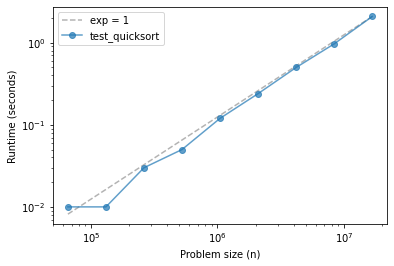

In [23]:
import numpy as np

def test_quicksort(n):
    xs = np.random.normal(size=n)
    xs.sort(kind='quicksort')

ns, ts = run_timing_test(test_quicksort)
plot_timing_test(ns, ts, 'test_quicksort', exp=1)

quicksort is hard to distinguish from linear, up to about 10 million elements.

1024 0.0
2048 0.0
4096 0.0
8192 0.0
16384 0.0
32768 0.0
65536 0.010000000000000675
131072 0.009999999999999787
262144 0.03000000000000025
524288 0.05999999999999961
1048576 0.1200000000000001
2097152 0.2699999999999996
4194304 0.5499999999999998
8388608 1.160000000000001


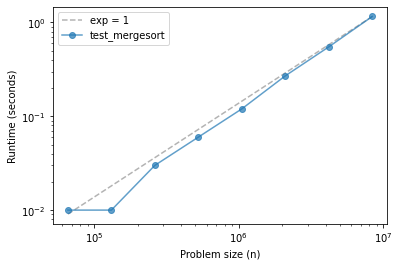

In [24]:
def test_mergesort(n):
    xs = np.random.normal(size=n)
    xs.sort(kind='mergesort')

ns, ts = run_timing_test(test_mergesort)
plot_timing_test(ns, ts, 'test_mergesort', exp=1)

Merge sort is similar, maybe with some upward curvature.

1024 0.0
2048 0.0
4096 0.0
8192 0.0
16384 0.0
32768 0.0
65536 0.009999999999999787
131072 0.009999999999999787
262144 0.030000000000001137
524288 0.049999999999998934
1048576 0.10999999999999943
2097152 0.21000000000000085
4194304 0.4499999999999993
8388608 0.9800000000000004
16777216 1.9700000000000006


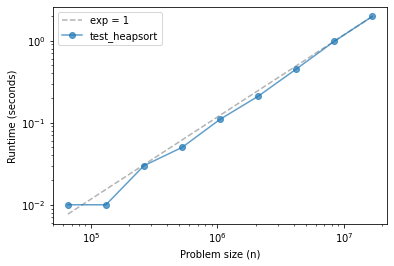

In [25]:
def test_heapsort(n):
    xs = np.random.normal(size=n)
    xs.sort(kind='heapsort')

ns, ts = run_timing_test(test_quicksort)
plot_timing_test(ns, ts, 'test_heapsort', exp=1)

The three methods are effectively linear over this range of problem sizes.

And their run times are about the same, with quicksort being the fastest, despite being the one with the worst asympotic performance in the worst case.

Now let's see how our implementation of merge sort does.

1024 0.0
2048 0.009999999999999787
4096 0.010000000000001563
8192 0.02999999999999936
16384 0.0600000000000005
32768 0.11999999999999922
65536 0.2599999999999998
131072 0.5300000000000011
262144 1.089999999999998


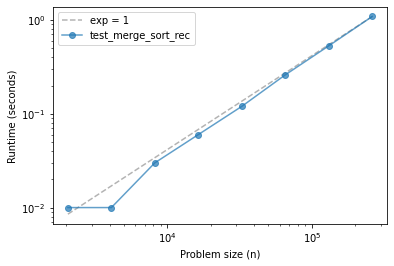

In [26]:
def test_merge_sort_rec(n):
    xs = np.random.normal(size=n)
    spectrum = merge_sort_rec(xs)

ns, ts = run_timing_test(test_merge_sort_rec)
plot_timing_test(ns, ts, 'test_merge_sort_rec', exp=1)

If things go according to plan, our implementation of merge sort should be close to linear, or a little steeper.

*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)